**2. DATA EXPLORATION:**

2.1 Loading and Inspecting data

In [1]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(train_df.shape)
print(train_df.dtypes)

(200000, 202)
ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object


Training data shape = (200,000, 202),
Columns: ID_code (object/string), target (int: 0 or 1), var_0 to var_199 (float64)

2.2 Feature Ranges

In [2]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


**2.3. Preprocessing**

Drop non-informative columns:  ID_code is an identifier and should not be used for training.

In [2]:
X = train_df.drop(columns = ["ID_code", "target"])
y = train_df["target"]

X_test = test_df.drop(columns = ["ID_code"])

**2.2 Feature Scaling**

Neural networks are sensitive to feature scale. Features have different ranges. Standardization stabilizes gradients and accelerates convergence

In [ ]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

**2.5. Dataset and DataLoader**

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset

class SantanderDataset(Dataset):
    def __init__(self, X, y =None):
        self.X = torch.tensor(X, dtype =torch.float32)
        self.y = None if y is None else torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        if self.y is None:
            return self.X[index]
        return self.X[index], self.y[index]
    
train_ds = SantanderDataset(X_scaled, y)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

In [13]:
test_dataset = SantanderDataset(X_test_scaled)
test_loader = DataLoader(test_dataset, batch_size=512,shuffle=False)

**3. Neural Network Design**

3.1 Model Architecture

In [10]:
import torch.nn as nn

class SantanderNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(200, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128,1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

3.2 Loss function and Optimizer

Binary classification is dealt by BCEWithLogitsLoss function

Adam handles sparse gradients and noisy features well

In [7]:
model = SantanderNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

**4. Training with loss and AUC training:**

**4.1 AUC Metric and Tensorboard setup**

In [ ]:
!pip install tensorboard


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from sklearn.metrics import roc_auc_score
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/santander_exp1")

**4.3 Training Loop**

In [8]:
epochs = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    preds, targets = [], []

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds.extend(torch.sigmoid(logits).detach().numpy())
        targets.extend(yb.numpy())

    auc_roc = roc_auc_score(targets, preds)

    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("AUC/train", auc_roc, epoch)

    print(f"Epoch {epoch}: Loss={epoch_loss:.4f}, AUC={auc_roc:.4f}")

Epoch 0: Loss=197.6447, AUC=0.8285
Epoch 1: Loss=186.2554, AUC=0.8520
Epoch 2: Loss=182.6466, AUC=0.8581
Epoch 3: Loss=180.1848, AUC=0.8621
Epoch 4: Loss=177.4589, AUC=0.8655
Epoch 5: Loss=175.2182, AUC=0.8687
Epoch 6: Loss=172.1557, AUC=0.8725
Epoch 7: Loss=169.0401, AUC=0.8767
Epoch 8: Loss=167.5282, AUC=0.8786
Epoch 9: Loss=163.7289, AUC=0.8833
Epoch 10: Loss=161.8713, AUC=0.8856
Epoch 11: Loss=159.2179, AUC=0.8889
Epoch 12: Loss=156.9468, AUC=0.8922
Epoch 13: Loss=155.8262, AUC=0.8941
Epoch 14: Loss=153.2885, AUC=0.8974
Epoch 15: Loss=151.8012, AUC=0.8989
Epoch 16: Loss=150.4291, AUC=0.9003
Epoch 17: Loss=149.0055, AUC=0.9027
Epoch 18: Loss=147.6577, AUC=0.9042
Epoch 19: Loss=147.0513, AUC=0.9047
Epoch 20: Loss=145.0124, AUC=0.9076
Epoch 21: Loss=144.4192, AUC=0.9087
Epoch 22: Loss=142.3613, AUC=0.9117
Epoch 23: Loss=140.6956, AUC=0.9142
Epoch 24: Loss=139.8519, AUC=0.9154
Epoch 25: Loss=138.3777, AUC=0.9171
Epoch 26: Loss=137.8740, AUC=0.9174
Epoch 27: Loss=137.3427, AUC=0.9187
Ep

In [26]:
!tensorboard --logdir=runs

^C


**5. Optimization Using Hyperparameters:**

**5.1 Try different parameters (like training epochs, learning rate, etc.) of your model, and also try different optimizers. Check whether these changes can improve the model's performance.**

In [9]:
import torch.nn as nn

class SantanderNet(nn.Module):
    def __init__(self, dropout_rate=0.3):  # <-- add this parameter
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(200, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # use the parameter
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()


In [22]:
experiments = [
    {"name": "Baseline", "lr": 1e-3, "optimizer": "Adam", "dropout": 0.3}, #previous one
    {"name": "LowerLR", "lr": 1e-4, "optimizer": "Adam", "dropout":0.3},
    {"name": "Lower LR", "lr": 1e-4, "optimizer": "Adam", "dropout": 0.3},
    {"name": "SGD optimizer", "lr": 1e-2, "optimizer": "SGD", "dropout": 0.3},
    {"name": "High Dropout", "lr": 1e-3, "optimizer": "Adam", "dropout": 0.5}
]

In [23]:
results = []

for exp in experiments:
    print(f"\nRunning experiment: {exp['name']}")
    model = SantanderNet(dropout_rate=exp["dropout"])
    
    # Choosing optimizer
    if exp["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=exp["lr"])
    elif exp["optimizer"] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=exp["lr"], momentum=0.9)
    
    criterion = nn.BCEWithLogitsLoss()

    epochs = 50

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        preds, targets = [], []
        
        for xb, yb in train_loader:
            xb = xb.float()
            yb = yb.float()
            
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            preds.extend(torch.sigmoid(logits).detach().numpy())
            targets.extend(yb.numpy())
        
        auc_roc = roc_auc_score(targets, preds)
    
    print(f"Final Loss: {epoch_loss:.4f}, Final AUC: {auc_roc:.4f}")
    results.append({
        "Experiment": exp["name"],
        "Learning Rate": exp["lr"],
        "Optimizer": exp["optimizer"],
        "Dropout": exp["dropout"],
        "Final AUC": round(auc_roc, 4),
        "Final Loss": round(epoch_loss, 4)
    })                                      


Running experiment: Baseline
Final Loss: 125.8619, Final AUC: 0.9251

Running experiment: LowerLR
Final Loss: 152.6475, Final AUC: 0.8985

Running experiment: Lower LR
Final Loss: 153.4008, Final AUC: 0.8974

Running experiment: SGD optimizer
Final Loss: 139.9438, Final AUC: 0.9192

Running experiment: High Dropout
Final Loss: 152.3677, Final AUC: 0.8896


In [24]:
import pandas as pd
results_df = pd.DataFrame(results)
print("\nSummary of experiments:")
print(results_df)


Summary of experiments:
      Experiment  Learning Rate Optimizer  Dropout  Final AUC  Final Loss
0       Baseline         0.0010      Adam      0.3     0.9251    125.8619
1        LowerLR         0.0001      Adam      0.3     0.8985    152.6475
2       Lower LR         0.0001      Adam      0.3     0.8974    153.4008
3  SGD optimizer         0.0100       SGD      0.3     0.9192    139.9438
4   High Dropout         0.0010      Adam      0.5     0.8896    152.3677


**5.2 Write a code to count the amount of data samples with different target labels. What do you observe about the distribution of the target labels? How did this situation affect your model training and performance? What techniques can you use to solve this issue to improve model training, and make the training data received by the model more balanced? Do you think these techniques will improve your model’s performance? Why or why not?**

In [12]:
import pandas as pd

#Counting number of samples for different label:
label_counts = train_df['target'].value_counts()
print(label_counts)

target
0    179902
1     20098
Name: count, dtype: int64


The output shows that the dataset is highly imbalanced, with a significantly larger number of samples labeled as class 0 compared to class 1.
In the Santander dataset, approximately 90% of samples belong to class 0, while only about 10% belong to class 1.

This indicates a strong class imbalance problem, which is common in real-world binary classification tasks such as fraud detection or customer behavior prediction.

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in train_loader:
        logits = model(xb)
        probs = torch.sigmoid(logits)

        all_preds.extend(probs.numpy())
        all_targets.extend(yb.numpy())

# Convert probabilities to 0/1 using threshold
y_pred = (np.array(all_preds) >= 0.5).astype(int)
y_true = np.array(all_targets).astype(int)

cm = confusion_matrix(y_true, y_pred)
print(cm)


[[179870     32]
 [  9274  10824]]


This imbalance affects model training by becoming biased toward the majority class. Predicting class 0 frequently can still yield high accuracy, even if class 1 is poorly predicted. The model may show low recall for the minority class (as seen above). Loss optimization is dominated by majority-class samples. Because of this, AUC is a more appropriate evaluation metric than accuracy.

The Techniques used to handle imbalance:

1. Class weighting in the loss function: Assign higher penalty to misclassification of minority-class samples

2. Oversampling the minority class: Duplicate or resample minority samples more frequently during training

3. Undersampling the majority class: Reduce the number of majority-class samples

4. Synthetic data generation (e.g., SMOTE): Generate artificial minority-class samples

References:
1. Goodfellow, I., Bengio, Y., & Courville, A. (2016).Deep Learning. MIT Press. Chapter 6: Optimization for Training Deep Models.
2. Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique.
Journal of Artificial Intelligence Research, 16, 321–357.
3. He, H., & Garcia, E. A. (2009). Learning from Imbalanced Data. IEEE Transactions on Knowledge and Data Engineering, 21(9), 1263–1284.
4. Han, H., Wang, W.-Y., & Mao, B.-H. (2005). Borderline-SMOTE: A New Over-Sampling Method in Imbalanced Data Sets Learning.

Yes, these techniques can improve model performance, particularly in minority-class recall, AUC score, and model robustness. However, they may also introduce trade-offs like oversampling can cause overfitting and undersampling may discard useful information

**5.3  Do not set the specific training epochs, but let the model loss converge (set a threshold of difference loss between two epochs) to automatically terminate the training.**  

Here, instead of fixing the number of training epochs, the training process can be terminated automatically when the model loss converges. Convergence is defined as the situation where the absolute difference in loss between two consecutive epochs falls below a predefined threshold.

Convergence Criterion

Let:
$\Delta L = \lvert L_{\text{epoch}} - L_{\text{epoch}-1} \rvert$

Training is stopped when:
$\Delta L < \epsilon$

where 
𝜖
ϵ is a small threshold (e.g., 1e-4).

In [ ]:
max_epochs = 10000         # upper bound to avoid infinite loop
loss_threshold = 1e-3     # convergence threshold
prev_loss = float("inf")

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    preds, targets = [], []

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds.extend(torch.sigmoid(logits).detach().numpy())
        targets.extend(yb.numpy())

    auc_roc = roc_auc_score(targets, preds)

    # TensorBoard logging
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("AUC/train", auc_roc, epoch)

    print(f"Epoch {epoch}: Loss={epoch_loss:.4f}, AUC={auc_roc:.4f}")

    # Check convergence
    if abs(prev_loss - epoch_loss) < loss_threshold:
        print(
            f"Training stopped at epoch {epoch} "
            f"due to loss convergence (ΔLoss < {loss_threshold})"
        )
        break

    prev_loss = epoch_loss

Epoch 0: Loss=199.4834, AUC=0.8257
Epoch 1: Loss=185.9475, AUC=0.8518
Epoch 2: Loss=182.8159, AUC=0.8569
Epoch 3: Loss=179.9891, AUC=0.8615
Epoch 4: Loss=177.6393, AUC=0.8653
Epoch 5: Loss=175.2525, AUC=0.8679
Epoch 6: Loss=172.5736, AUC=0.8721
Epoch 7: Loss=170.0727, AUC=0.8745
Epoch 8: Loss=167.4146, AUC=0.8784
Epoch 9: Loss=165.2250, AUC=0.8805
Epoch 10: Loss=162.8090, AUC=0.8839
Epoch 11: Loss=159.7089, AUC=0.8876
Epoch 12: Loss=158.2164, AUC=0.8901
Epoch 13: Loss=156.2568, AUC=0.8928
Epoch 14: Loss=154.7832, AUC=0.8944
Epoch 15: Loss=153.1670, AUC=0.8963
Epoch 16: Loss=151.0872, AUC=0.8991
Epoch 17: Loss=148.7753, AUC=0.9024
Epoch 18: Loss=147.9022, AUC=0.9031
Epoch 19: Loss=146.7045, AUC=0.9052
Epoch 20: Loss=144.8963, AUC=0.9073
Epoch 21: Loss=143.3683, AUC=0.9096
Epoch 22: Loss=141.8346, AUC=0.9118
Epoch 23: Loss=141.2975, AUC=0.9120
Epoch 24: Loss=140.5693, AUC=0.9132
Epoch 25: Loss=138.8093, AUC=0.9160
Epoch 26: Loss=138.4077, AUC=0.9152
Epoch 27: Loss=136.6928, AUC=0.9182
Ep

**6. Final Step: Inference on Test Data and Kaggle Submission**

After optimizing the model, the final trained network was used to perform inference on the Kaggle test dataset to generate predictions for submission.

**6.1 Running Inference on Test Data**

The Baseline model (model()) with  Learning Rate 0.001 and Adam Optimizer with Dropout 0.3 gave the highest AUC of 0.9251 and lowest Loss of 125.862. Thus it will be used to run inference on the test data

In [ ]:
model.eval()
test_preds = []

with torch.no_grad():
    for xb in test_loader:
        logits = model(xb)
        probs = torch.sigmoid(logits)
        test_preds.extend(probs.cpu().numpy())

**6.2 Count how many predictions would be class 1 if threshold=0.5**

In [16]:
!pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------------------------- ------ 6.8/8.1 MB 35.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 29.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 13.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


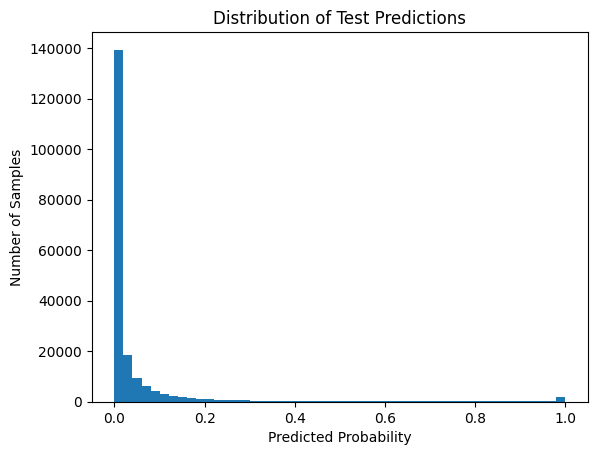

In [17]:
import matplotlib.pyplot as plt

plt.hist(test_preds, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Samples")
plt.title("Distribution of Test Predictions")
plt.show()

In [20]:
import numpy as np
threshold = 0.5
test_preds = np.array(test_preds) 

pred_classes = (test_preds >= threshold).astype(int)  # now works
unique, counts = np.unique(pred_classes, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(193803), np.int64(1): np.int64(6197)}


**6.3 Create Kaggle Submission File**

In [ ]:
submission = pd.DataFrame({
    "ID_code": test_df["ID_code"],
    "target": test_preds
})

submission.to_csv("submission.csv", index=False)